In [1]:
#!pip install plotly
#!pip install patsy

# %load_ext autoreload
# %autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, cm
from matplotlib import colors

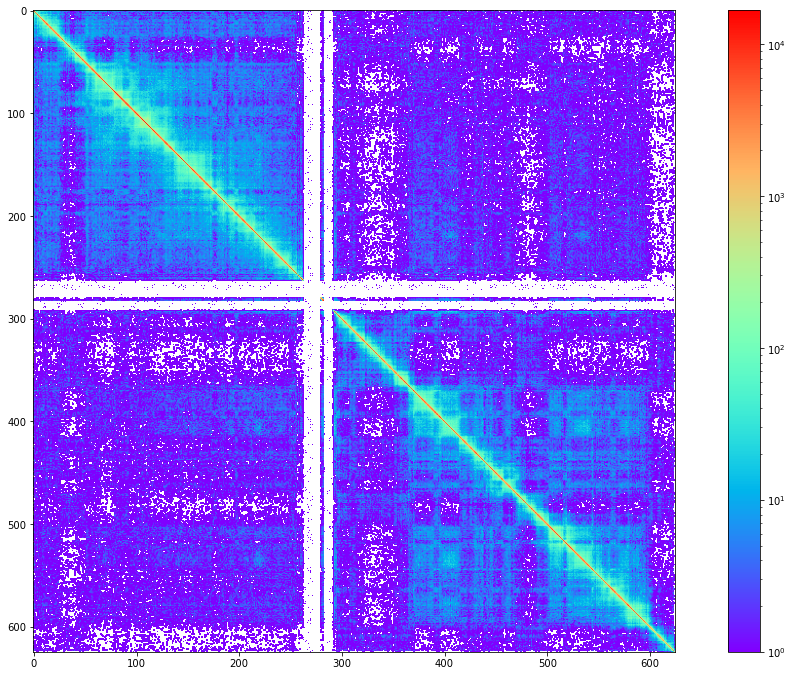

C shape (625, 625)


In [10]:
path = '..//data//IMR90_100kb_chr20.csv'
C = np.array(pd.read_csv(f'{path}', header=None))


plt.rcParams["figure.figsize"] = [15.00, 9.50]
plt.rcParams["figure.autolayout"] = True
im = plt.imshow(C, cmap=cm.rainbow, norm=colors.LogNorm())
plt.colorbar(im)
plt.show()

print('C shape', C.shape)

In [11]:
path = '..//data//C.csv'
C_test = np.array(pd.read_csv(path, header=None))
path = '..//data//H.csv'
H_test = np.array(pd.read_csv(path, header=None))
path = '..//data//Ho.csv'
Q_test = np.array(pd.read_csv(path, header=None))
path = '..//data//Z.csv'
Z_test = np.array(pd.read_csv(path, header=None))

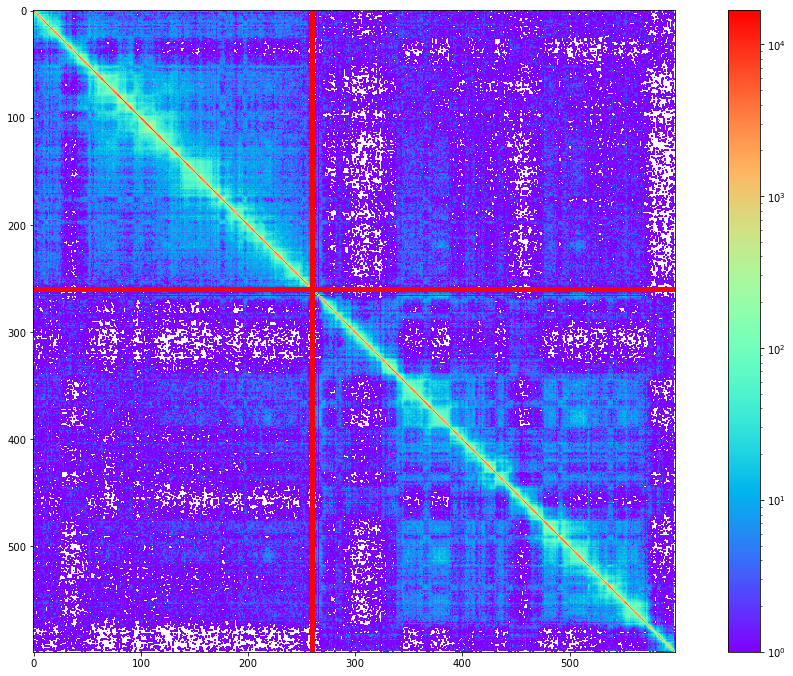

C shape (599, 599)


In [145]:
mask = (C == 0).all(0)
# Find the indices of these columns
index = np.where(~mask)[0]
C = C[~mask,:]
C = C[:,~mask]

plt.rcParams["figure.figsize"] = [15.00, 9.50]
plt.rcParams["figure.autolayout"] = True
im = plt.imshow(C, cmap=cm.rainbow, norm=colors.LogNorm())
plt.axhline(y=260, color='r', linestyle='-', linewidth = 5)
plt.axvline(x=260, color='r', linestyle='-', linewidth = 5)
plt.colorbar(im)
plt.show()

print('C shape', C.shape)

In [62]:
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree

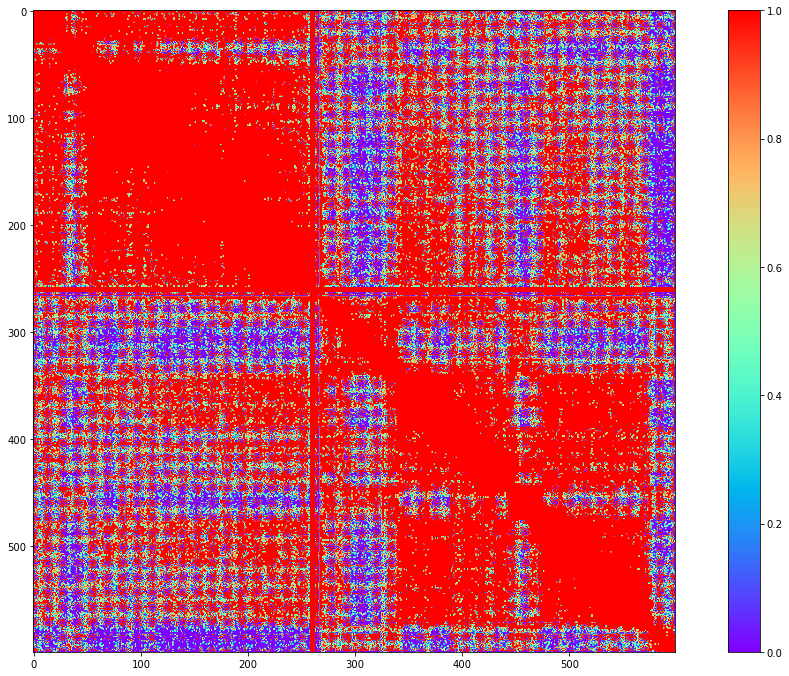

In [13]:
np.isclose(C, C_test)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [14]:
import patsy

H shape: (599, 25)


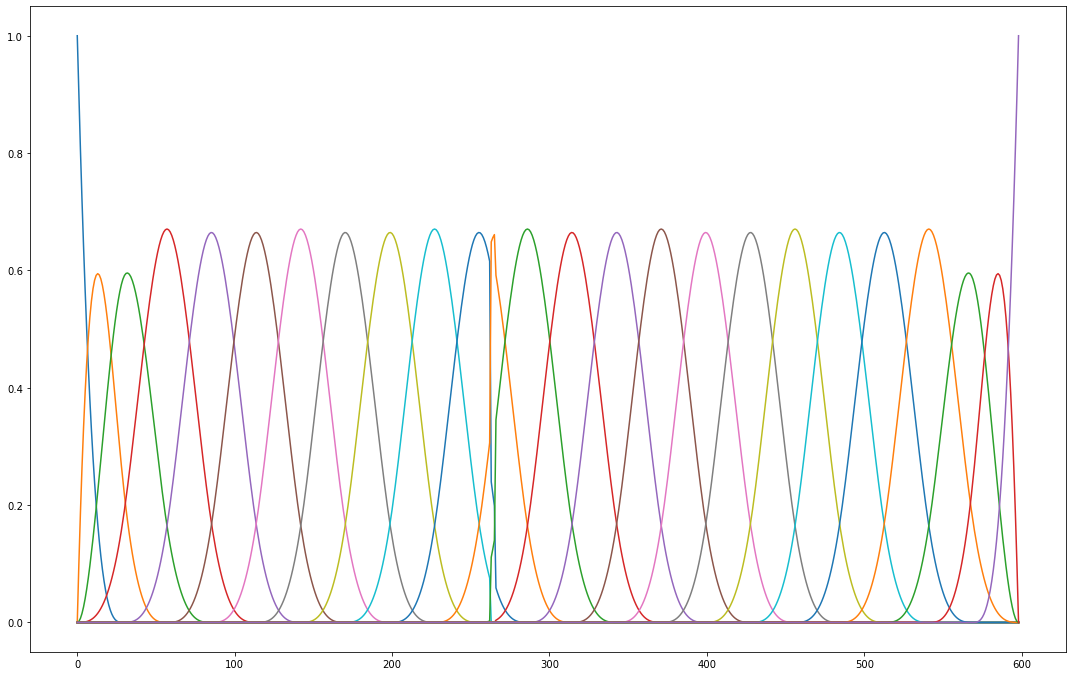

In [15]:
df = 27
n_knots = df - 4 
knots = np.linspace(1, max(index), n_knots, dtype='int64')
knots = knots[1:n_knots-1]
#B0 = patsy.bs(index, df = df, include_intercept=True)#patsy.bs(index, knots=knots, include_intercept=True)
B0 = patsy.dmatrix("bs(x, knots=knots, include_intercept=True)-1", 
             {"x": index, "knots":knots}) # https://stats.stackexchange.com/questions/495991/meaning-of-design-matrix-in-context-of-bayesian-b-spline-regression
H = B0[::]
print('H shape:', H.shape)
plt.plot(H);

import scipy as sp

#Q, R = np.linalg.qr(H) # QR  
Q = sp.linalg.orth(H) # SVD https://stackoverflow.com/questions/54081800/np-linalg-qra-or-scipy-linalg-ortha-for-finding-the-orthogonal-basis-python

## QR: loss 0.035, SVD: loss: 0.029

In [16]:
#
# plt.plot(H_test);
#plt.plot(H);

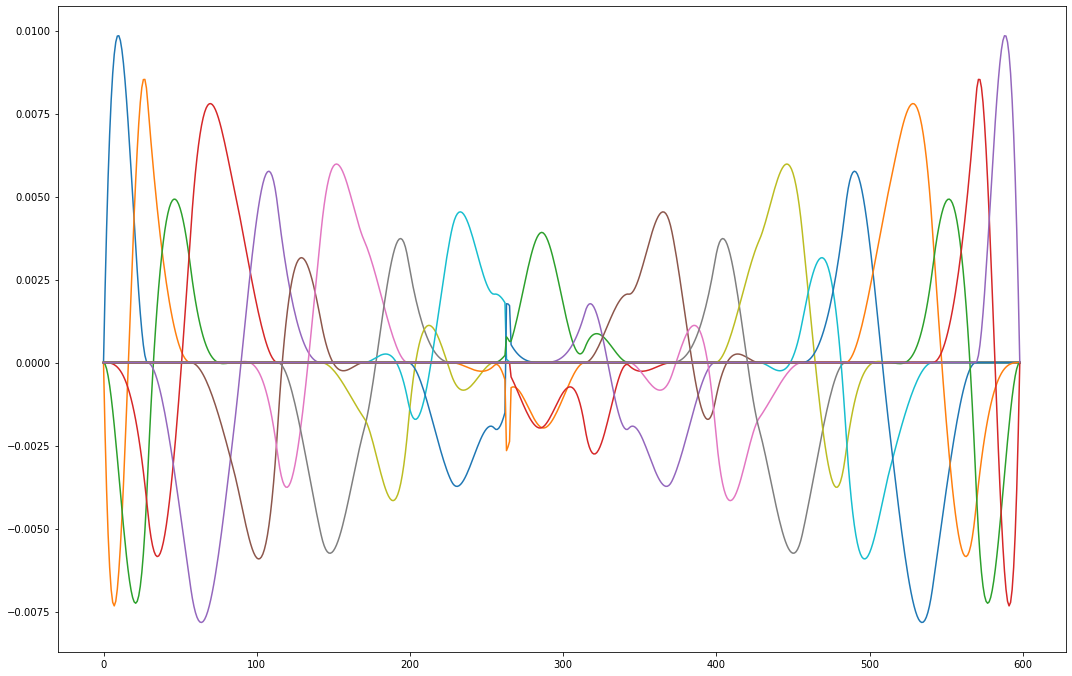

In [17]:
try: 
    np.isclose(H, H_test)
    plt.plot(H - H_test);
except:
    pass

In [18]:
def scale(y, center=True, scale=True):
    x = y.copy()
    if center:
        x -= x.mean(axis=0)
    if scale and center:
        x /= x.std()
    #elif scale:
    #    x /= np.sqrt(x.pow(2).sum().div(x.count() - 1))
    return x

In [19]:
D = 1/(C+1)
Z = -D**2/2
Z = scale(Z, center = True, scale = False)
Z = (scale(Z.T, center = True, scale = False)).T

In [20]:
try:
    print(np.isclose(Z, Z_test).sum()/599)
except:
    pass

599.0


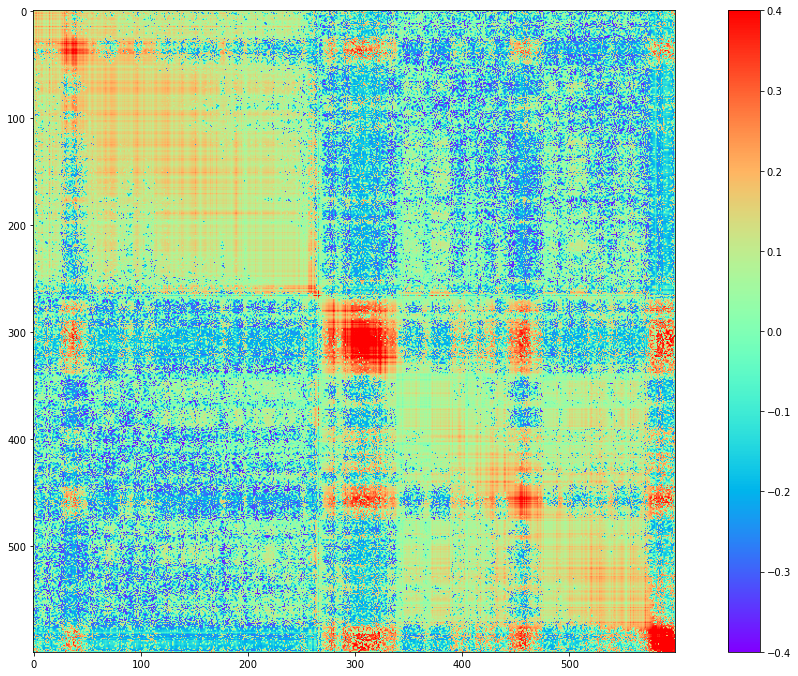

In [33]:
plt.rcParams["figure.figsize"] = [15.00, 9.50]
plt.rcParams["figure.autolayout"] = True
im = plt.imshow(Z, cmap=cm.rainbow, norm=colors.Normalize(vmin=-0.4, vmax=0.4))
plt.colorbar(im)
plt.show()

In [34]:
np.zeros

<function numpy.zeros>

In [35]:
loss_PCMS = lambda X, Z: np.mean((Z - X @ X.T)**2)
def PCMS(Z, H, k = 3, symmetric=True):
    ED = sp.linalg.eig(H.T @ Z @ H)
    sorted_eigval_ind = np.argsort(-ED[0].real)
    d3 = np.real(ED[0][sorted_eigval_ind][:k])
    U3 = np.real(ED[1][sorted_eigval_ind][:, :k])
    rank = np.sum(d3 > 1e-12)
    d3 = np.maximum(0, d3)
    Theta = U3 @ np.diag(np.sqrt(d3))
    #return U3, np.diag(np.sqrt(d3))
    X = H @ Theta
    return {'Theta':Theta,
    'X': X,
    'loss': loss_PCMS(X, Z),
    'rank': rank}

Python only version
The optimal loss value is 0.03096296004826874


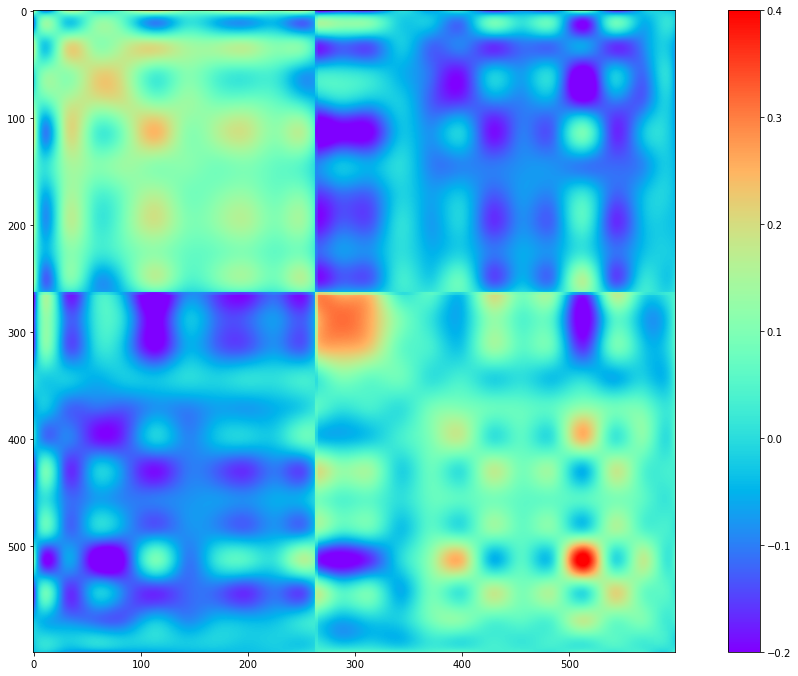

In [36]:
print('Python only version')
Theta, X, loss, rank = PCMS(Z, sp.linalg.orth(H), symmetric=False).values()
Z_hat = X @ X.T
print('The optimal loss value is', loss)
plt.rcParams["figure.figsize"] = [15.00, 9.50]
plt.rcParams["figure.autolayout"] = True

im = plt.imshow(Z_hat, cmap=cm.rainbow, norm=colors.Normalize(vmin=-0.2, vmax=0.4))
plt.colorbar(im)
plt.show()

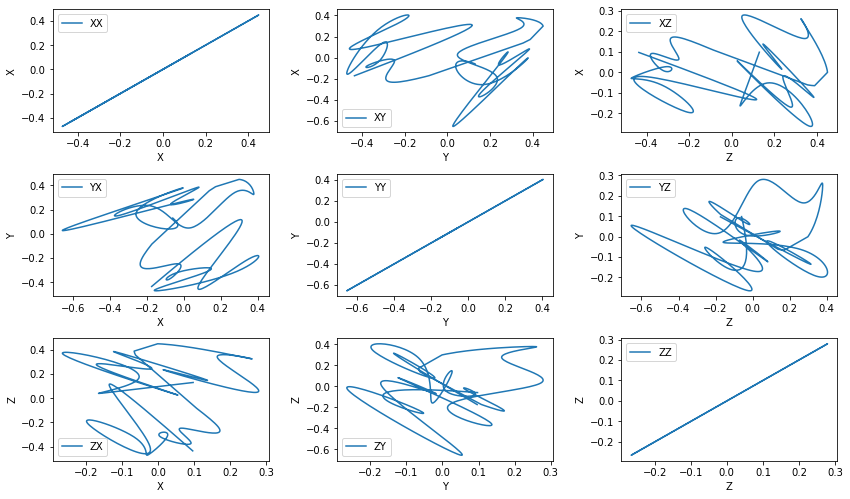

In [37]:
nrow = 3; ncol = 3;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12, 7))
coords = [
    [0, 0],
    [0, 1],
    [0, 2],
    [1, 0],
    [1, 1],
    [1, 2],
    [2, 0],
    [2, 1],
    [2, 2]
]
labels = [
    'XX',
    'XY',
    'XZ',
    'YX',
    'YY',
    'YZ',
    'ZX',
    'ZY',
    'ZZ'
]
for (i,j), label in zip(coords, labels):
    axs[i, j].plot(X[:, i], X[:, j], label=label)
    axs[i,j].set_xlabel(label[1])
    axs[i,j].set_ylabel(label[0])
    axs[i,j].legend()

In [26]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter3d(
    x=X[:, 0], y=X[:, 1], z=X[:, 2],
    marker=dict(
        size=4,
        color =X[:, 1],
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
))

fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig.show()

# WPCMS

C:\Users\user\AppData\Local\Temp\ipykernel_5024\3888105336.py:3: RuntimeWarning:

divide by zero encountered in log



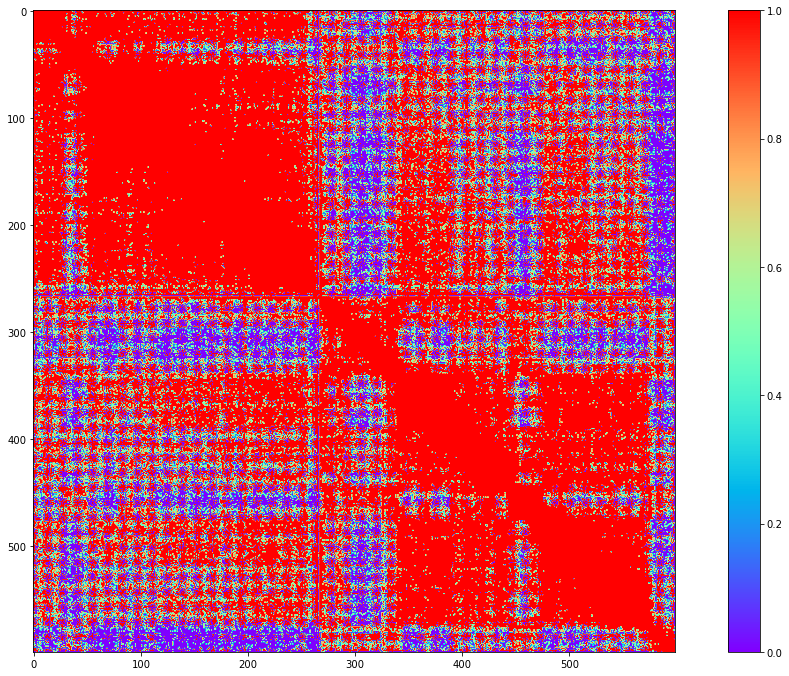

In [38]:
W = np.ones(C.shape)
W[C == 0] = 0
log_C = np.log(C)
log_C[C == 0] = 0
plt.rcParams["figure.autolayout"] = True

im = plt.imshow(W, cmap=cm.rainbow, norm=colors.Normalize(vmin=0, vmax=1))
plt.colorbar(im)
plt.show()

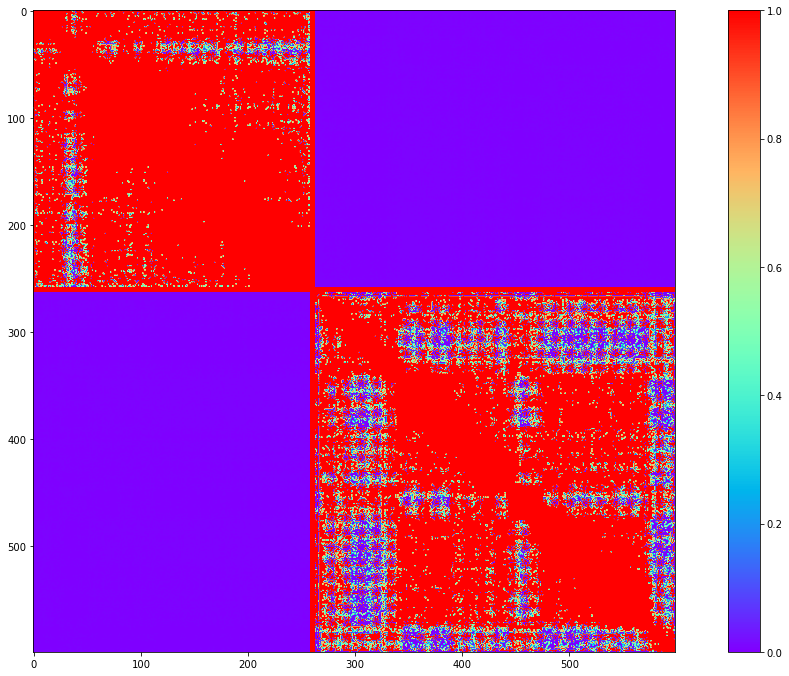

In [172]:
lambda_ = 0.005
T = np.block([
    [np.ones_like(C[:260, :260]),np.ones_like(C[:260, 260:])*lambda_],
    [np.ones_like(C[260:, :260])*lambda_,np.ones_like(C[260:, 260:])]
])
im = plt.imshow(W*T, cmap=cm.rainbow)
plt.axhline(y=260, color='r', linestyle='-', linewidth = 5)
plt.axvline(x=260, color='r', linestyle='-', linewidth = 5)
plt.colorbar(im)
plt.show()


In [39]:
from sklearn.metrics import pairwise_distances
from scipy.spatial import procrustes

In [191]:
use_sp = False


pdist = lambda X: sp.spatial.distance.cdist(X,X) if use_sp else pairwise_distances(X)

def _get_gradient(G):
  G_plus = np.diag(G.sum(axis = 1))
  return G - G_plus

def gradient_step(S, G, rate):
  #print(np.linalg.norm(S - rate * (G - G_plus)))
  return S - rate * (_get_gradient(G))

def projection_step(S, H):
  pcms = PCMS(S, H)
  return pcms

def update_beta_WPCMS(X, Z, W):
  D = pdist(X)
  beta = -np.sum(W *(Z - D**2))/np.sum(W)
  return beta



def loss_WPCMS(X, Z, W, beta):
    D = pdist(X)
    return(np.mean(W *(Z - D**2 + beta)**2))

def WPCMS_rate(Theta, X, loss, Z, H, W, k = 3):
  D = pdist(X)
  S = X @ X.T
  G = W * (Z - D**2)
  rate = 1
  pgd = projection_step(gradient_step(S, G, rate), H)
  while (loss < loss_WPCMS(pgd['X'], Z, W, 0) or pgd['rank'] < k):
    rate = rate * 0.5
    pgd = projection_step(gradient_step(S, G, rate), H)
    if rate < 1e-20:
        #print(type(X))
        return {'Theta': Theta, 'X': X, 'rate': 0}
  return {
    'Theta': pgd['Theta'],
    'X': pgd['X'],
    'rate': rate
  }


def WPCMS(
    Z,
    H,
    W,
    beta0,
    Theta0,
    update_beta = True,
    eps = 1e-6,
    maxiter = 100,
    verbose = True
):
    n = H.shape[0]
    df = H.shape[1]
    beta = beta0
    betas = [beta]
    Theta = Theta0
    X = H @ Theta
    X = scale(X, scale = False, center = True)
    loss = loss_WPCMS(X, Z, W, beta)
    print(loss)
    losses = [loss]
    
    delta = np.inf
    #deltaX = np.inf
    iter = 0
    while(delta > eps and iter < maxiter):
      if verbose:
        print('Objective function:', loss)
      #print(loss)
      iter += 1
      #Line search
      find = WPCMS_rate(Theta, X, loss, Z + beta, H, W)
      #Update solution
      Theta = find['Theta']
      X_new = find['X']
      #print(type(X_new))
      X_new = scale(X_new, scale = False, center = True)
      #print(procrustes(X, X_new))
      #deltaX = procrustes(X, X_new)
      X = X_new
      #Update beta
      if update_beta:
        beta = update_beta_WPCMS(X, Z, W)
      #betas.append(beta)
      #Update loss
      loss_new = loss_WPCMS(X, Z, W, beta)
      delta = abs((loss - loss_new)/loss)
      loss = loss_new
      #print(delta)
      
      #losses.append(loss)
      #if(verbose):
      #print("WPCMS Objective:", loss)
    return {
      'Theta': Theta,
      'X': X,
      'beta': beta,
      'loss': loss,
      'iter': iter
    }#[Theta, X, beta, loss, iter]
#H_test_q = sp.linalg.orth(H_test)


1.4329306763403036
Objective function: 1.4329306763403036
Objective function: 0.865394482911719
Objective function: 0.8433224830139382
Objective function: 0.8416833943008251
Objective function: 0.829280797131148
Objective function: 0.8079774449362503
Objective function: 0.7655594366804781
Objective function: 0.7263265154700408
Objective function: 0.7137110374550716
Objective function: 0.70133879853979


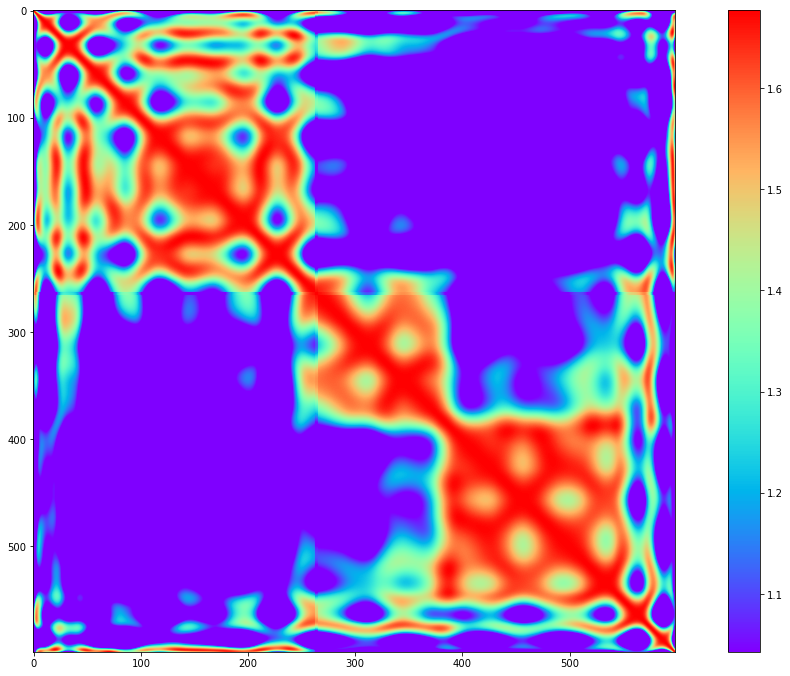

In [192]:
beta0 = -np.min(Z)
USE_T = True
lambda_ = 0.5
T = np.block([
    [np.ones_like(C[:260, :260]),np.ones_like(C[:260, 260:])*lambda_],
    [np.ones_like(C[260:, :260])*lambda_,np.ones_like(C[260:, 260:])]
])
T = T if USE_T else np.eye(N = W.shape[0])
np.random.seed(0); Theta0 = np.random.normal(size = (H.shape[1], 3))
Theta, X, beta, loss, iter = WPCMS(-log_C, sp.linalg.orth(H), beta0=beta0, Theta0=Theta0, W = W, eps = 1e-9, maxiter = 1000, verbose = True).values()
D = pairwise_distances(X)
logL = -D**2 + beta

plt.rcParams["figure.autolayout"] = True

im = plt.imshow(logL, cmap=cm.rainbow, norm=colors.Normalize(vmin=logL.mean(), vmax=logL.max()))
plt.colorbar(im)
plt.show()

In [236]:
use_sp = False


pdist = lambda X: sp.spatial.distance.cdist(X,X) if use_sp else pairwise_distances(X)

def _get_gradient(G):
  G_plus = np.diag(G.sum(axis = 1))
  return G - G_plus

def gradient_step(S, G, rate):
  #print(np.linalg.norm(S - rate * (G - G_plus)))
  return S - rate * (_get_gradient(G))

def projection_step(S, H):
  pcms = PCMS(S, H)
  return pcms

def update_beta_WPCMS(X, Z, W, T):
  D = pdist(X)
  beta = -np.sum(W * T * (Z - D**2))/np.sum(W)
  return beta



def loss_WPCMS(X, Z, W, beta, T):
    D = pdist(X)
    return(np.mean(W * T *(Z - D**2 + beta)**2))

def WPCMS_rate(Theta, X, loss, Z, H, W, T, k = 3):
  D = pdist(X)
  S = X @ X.T
  G = W * T * (Z - D**2)
  rate = 1
  pgd = projection_step(gradient_step(S, G, rate), H)
  while (loss < loss_WPCMS(pgd['X'], Z, W, 0, T) or pgd['rank'] < k):
    rate = rate * 0.5
    pgd = projection_step(gradient_step(S, G, rate), H)
    if rate < 1e-20:
        #print(type(X))
        return {'Theta': Theta, 'X': X, 'rate': 0}
  return {
    'Theta': pgd['Theta'],
    'X': pgd['X'],
    'rate': rate
  }


def WPCMS(
    Z,
    H,
    W,
    T,
    beta0,
    Theta0,
    update_beta = True,
    eps = 1e-6,
    maxiter = 100,
    verbose = True
):
    n = H.shape[0]
    df = H.shape[1]
    beta = beta0
    betas = [beta]
    Theta = Theta0
    X = H @ Theta
    X = scale(X, scale = False, center = True)
    loss = loss_WPCMS(X, Z, W, beta, T)
    print(loss)
    losses = [loss]
    
    delta = np.inf
    #deltaX = np.inf
    iter = 0
    while(delta > eps and iter < maxiter):
      if verbose:
        print('Objective function:', loss)
      #print(loss)
      iter += 1
      #Line search
      find = WPCMS_rate(Theta, X, loss, Z + beta, H, W, T)
      #Update solution
      Theta = find['Theta']
      X_new = find['X']
      #print(type(X_new))
      X_new = scale(X_new, scale = False, center = True)
      #print(procrustes(X, X_new))
      #deltaX = procrustes(X, X_new)
      X = X_new
      #Update beta
      if update_beta:
        beta = update_beta_WPCMS(X, Z, W, T)
      #betas.append(beta)
      #Update loss
      loss_new = loss_WPCMS(X, Z, W, beta, T)
      delta = abs((loss - loss_new)/loss)
      loss = loss_new
      #print(delta)
      
      #losses.append(loss)
      #if(verbose):
      #print("WPCMS Objective:", loss)
    return {
      'Theta': Theta,
      'X': X,
      'beta': beta,
      'loss': loss,
      'iter': iter
    }#[Theta, X, beta, loss, iter]
#H_test_q = sp.linalg.orth(H_test)


1.3035682812455112
Objective function: 1.3035682812455112
Objective function: 0.8017703022441122
Objective function: 0.7943060038536403
Objective function: 0.7948230545658029
Objective function: 0.7903100079029621
Objective function: 0.7894403054687259


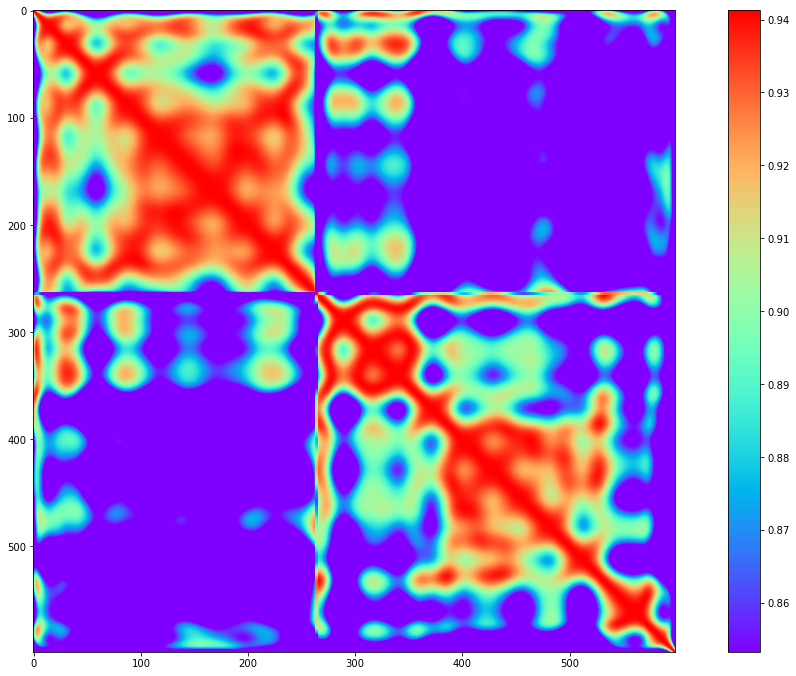

In [241]:
beta0 = -np.min(Z)
USE_T = True
lambda_ = 0.005
T = np.block([
    [np.ones_like(C[:260, :260]),np.ones_like(C[:260, 260:])*lambda_],
    [np.ones_like(C[260:, :260])*lambda_,np.ones_like(C[260:, 260:])]
])
T = T if USE_T else np.ones_like(W)
np.random.seed(0); Theta0 = np.random.normal(size = (H.shape[1], 3))
Theta, X, beta, loss, iter = WPCMS(-log_C, sp.linalg.orth(H), T=T, beta0=beta0, Theta0=Theta0, W = W, eps = 1e-9, maxiter = 1000, verbose = True).values()
D = pairwise_distances(X)
logL = -D**2 + beta

plt.rcParams["figure.autolayout"] = True

im = plt.imshow(logL, cmap=cm.rainbow, norm=colors.Normalize(vmin=logL.mean(), vmax=logL.max()))
plt.colorbar(im)
plt.show()

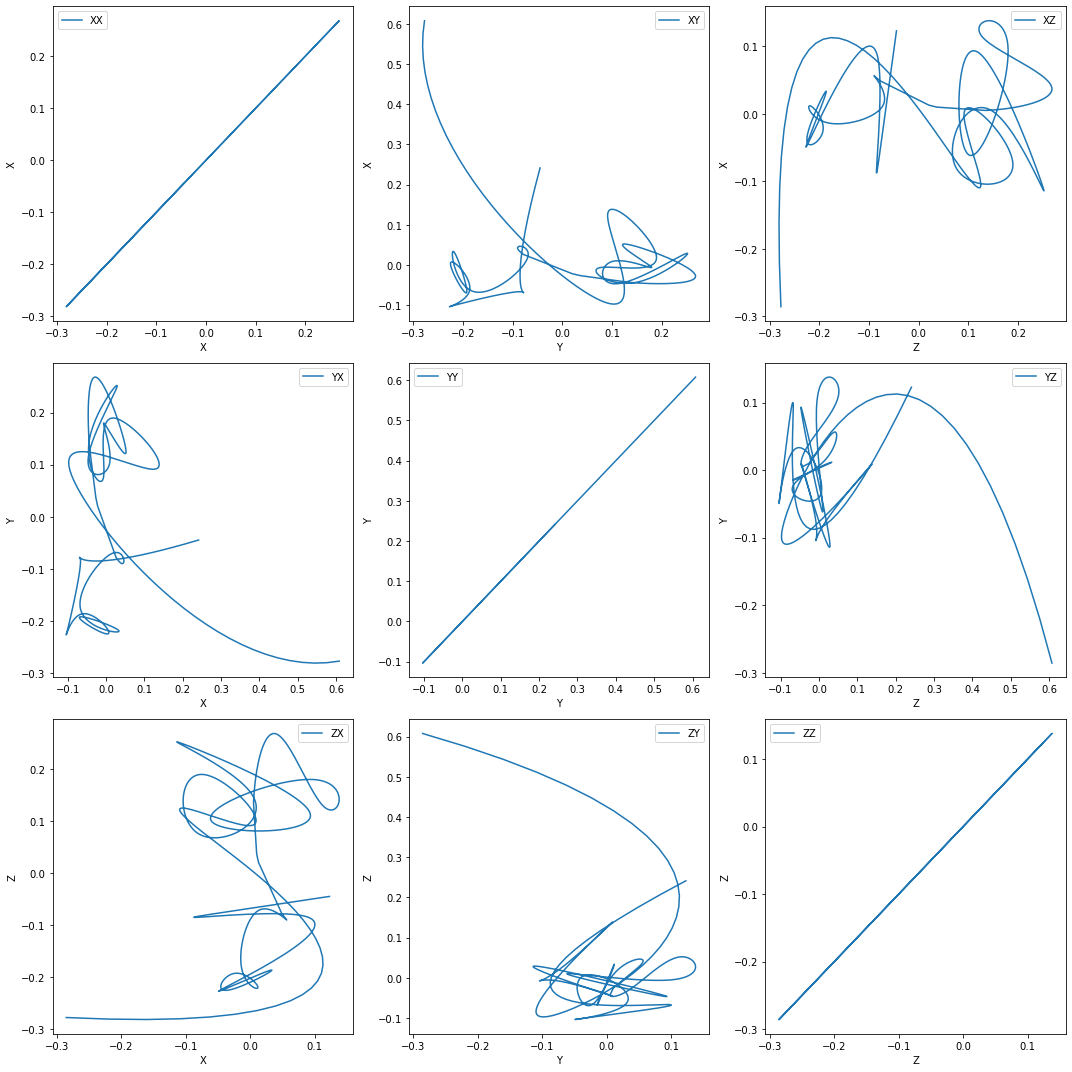

In [228]:
nrow = 3; ncol = 3;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15, 15))
coords = [
    [0, 0],
    [0, 1],
    [0, 2],
    [1, 0],
    [1, 1],
    [1, 2],
    [2, 0],
    [2, 1],
    [2, 2]
]
labels = [
    'XX',
    'XY',
    'XZ',
    'YX',
    'YY',
    'YZ',
    'ZX',
    'ZY',
    'ZZ'
]
for (i,j), label in zip(coords, labels):
    axs[i, j].plot(X[:, i], X[:, j], label=label)
    axs[i,j].set_xlabel(label[1])
    axs[i,j].set_ylabel(label[0])
    axs[i,j].legend()

In [229]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter3d(
    x=X[:, 0], y=X[:, 1], z=X[:, 2],
    marker=dict(
        size=4,
        color =X[:, 2],
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
))

fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig.show()

# PoisMS

In [34]:
#X = np.array([[-0.6878622, -1.6891723],[-1.0752929, -0.6519847]])
#Y = np.array([[0.9731003, 1.1529376], [-0.5587069, 0.8054816]])
#-4.440892e-16

In [242]:
def SOA(X, C, beta):
  D = pdist(X)
  logL = -D**2 + beta
  L = np.exp(logL)
  Z = D**2 - (C/L - 1)
  W = L
  return {
    'W': W, 
    'Z': Z
  }

def update_beta_PoisMS(X, C):
  D = pdist(X)
  beta = np.log(np.sum(C)/np.sum(np.exp(-D**2)))
  return(beta)

def loss_PoisMS(X, C, beta):
  D = pdist(X)
  logL = -D**2 + beta
  return(np.mean(np.exp(logL) - C * logL))

def PoisMS_rate(Theta, X_new, X, beta, loss, C, H, k = 3):
    rate = 1
    S = X @ X.T
    S_new = X_new @ X_new.T
    S_star = (1 - rate) * S + rate * S_new
    pcms = PCMS(S_star, H)
    while(loss < loss_PoisMS(pcms['X'], C, beta) or pcms['rank'] < k):
        rate = rate * 0.5
        S_star = (1 - rate) * S + rate * S_new
        pcms = PCMS(S_star, H)
        if rate < 1e-20:
          return {'Theta': Theta, 'X': X, 'rate': 0}
    return pcms
def PoisMS(
    C,
    H,
    T,
    beta0,
    Theta0,
    update_beta = True,
    eps_wpcms = 1e-6,
    maxiter = 100,
    eps_poisms = 1e-6,
    maxepoch = 100,
):
    n = H.shape[0]
    df = H.shape[1]
    beta = beta0
    betas = [beta]
    Theta = Theta0
    X = H @ Theta
    X = scale(X, scale = False, center=True)
    loss = loss_PoisMS(X, C, beta)
    losses = [loss]
    delta = np.inf
    deltaX = np.inf
    epoch = 0
    iter_total = 0
    while deltaX > eps_poisms and epoch < maxepoch:
        print('PoisMS', loss)
        epoch += 1
        soa = SOA(X, C, beta)
        W = soa['W']
        np.fill_diagonal(W, np.zeros_like(W.diagonal()))
        W = W/np.max(W)
        Z = soa['Z']
        wpcms = WPCMS(Z, H, W, T, 0, Theta, False, eps_wpcms, maxiter, verbose = False)
        iter_total += wpcms['iter']
        find = PoisMS_rate(Theta, wpcms['X'], X, beta, loss, C, H)
        Theta = find['Theta']
        X_new = find['X']
        X_new = scale(X_new, scale = False, center = True)
        deltaX = procrustes(X, X_new)[2]
        
        X = X_new
        #Update alpha and beta
        if update_beta:
            beta = update_beta_PoisMS(X, C)
        #betas = c(betas, beta)
        #Update loss
        loss_new = loss_PoisMS(X, C, beta)
        #delta = abs((loss - loss_new)/loss)
        delta = abs((loss - loss_new)/loss)
        loss = loss_new
        losses.append(loss)
    return {
      'Theta': Theta,
      'X': X,
      'beta': beta,
      'loss': loss,
      'losses': losses
    }
        

PoisMS 13191.572189983219
0.4181870423013065
PoisMS -31.62464709889267
1.0610213149684247
PoisMS -31.730242084736933
0.4900437929481719


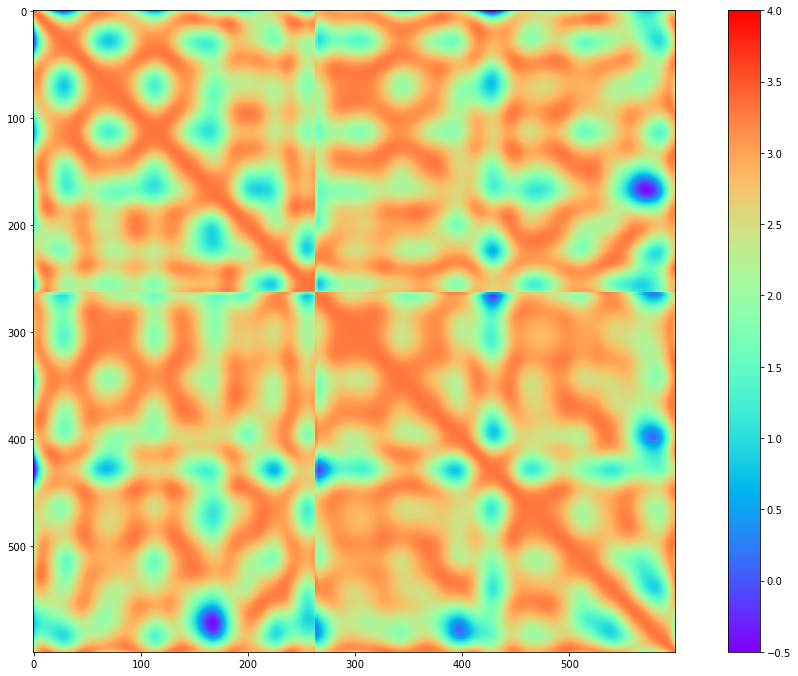

In [246]:
USE_T = True
lambda_ = 0.005
T = np.block([
    [np.ones_like(C[:260, :260]),np.ones_like(C[:260, 260:])*lambda_],
    [np.ones_like(C[260:, :260])*lambda_,np.ones_like(C[260:, 260:])]
])
T = T if USE_T else np.eye(N = W.shape[0])
np.random.seed(0); Theta0 = np.random.normal(size = (H.shape[1], 3))
Theta, X, beta, loss, losses = PoisMS(C, sp.linalg.orth(H), T, beta0=np.max(log_C), Theta0=Theta0,  eps_wpcms = 1e-8, maxiter = 200, eps_poisms = 1e-8, maxepoch = 1000).values()
D = pdist(X)
logL = -D**2 + beta
nrow = 1; ncol = 2;
#fig, axs = plt.subplots(nrows=nrow, ncols=ncol)

plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [15.00, 9.50]
im = plt.imshow(logL, cmap=cm.rainbow, norm=colors.Normalize(vmin=-0.5, vmax=4))
plt.colorbar(im)
plt.show()

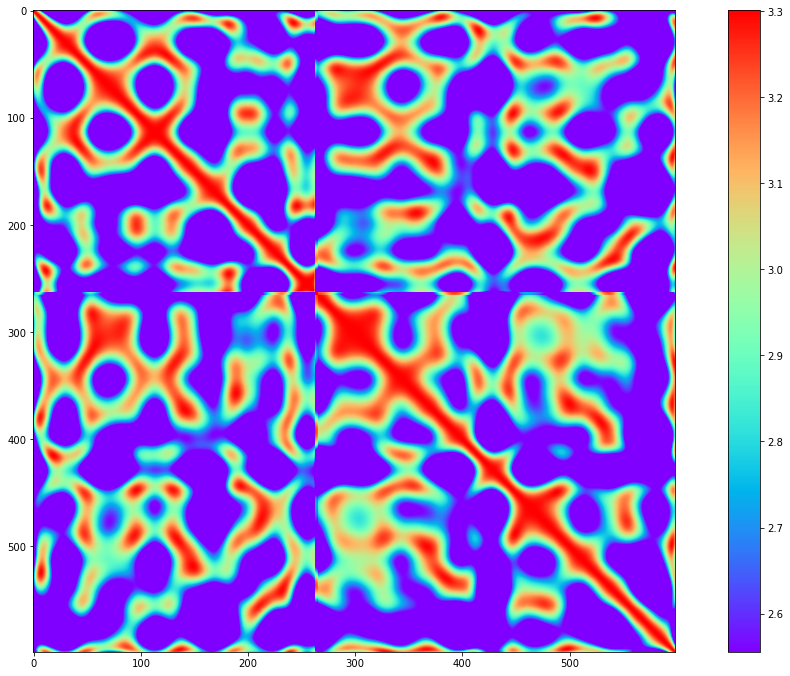

In [244]:
plt.rcParams["figure.autolayout"] = True
im = plt.imshow(logL, cmap=cm.rainbow, norm=colors.Normalize(vmin=logL.mean(), vmax=logL.max()))
plt.colorbar(im)
plt.show()

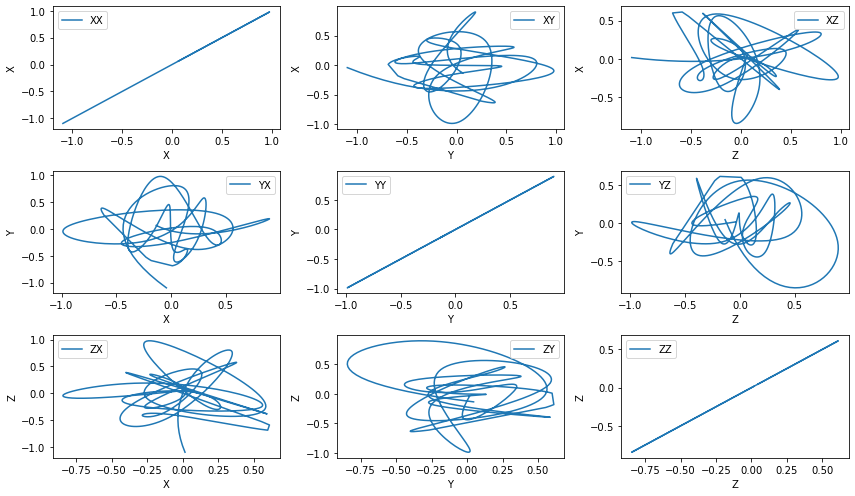

In [221]:
nrow = 3; ncol = 3;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12, 7))
coords = [
    [0, 0],
    [0, 1],
    [0, 2],
    [1, 0],
    [1, 1],
    [1, 2],
    [2, 0],
    [2, 1],
    [2, 2]
]
labels = [
    'XX',
    'XY',
    'XZ',
    'YX',
    'YY',
    'YZ',
    'ZX',
    'ZY',
    'ZZ'
]
for (i,j), label in zip(coords, labels):
    axs[i, j].plot(X[:, i], X[:, j], label=label)
    axs[i,j].set_xlabel(label[1])
    axs[i,j].set_ylabel(label[0])
    axs[i,j].legend()

In [222]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter3d(
    x=X[:, 0], y=X[:, 1], z=X[:, 2],
    marker=dict(
        size=4,
        color =X[:, 2],
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
))

fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    scene=dict(
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=0,
                y=1.0707,
                z=1,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig.show()